In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Carregando os dados e ajustando o datetime
tsla_data = pd.read_csv("data/TSLA.csv")
tsla_data["Date"] = pd.to_datetime(tsla_data["Date"])
tsla_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3556,2024-08-15,205.020004,215.880005,204.820007,214.139999,214.139999,89848500
3557,2024-08-16,211.149994,219.800003,210.800003,216.119995,216.119995,88765100
3558,2024-08-19,217.070007,222.979996,214.089996,222.720001,222.720001,76435200
3559,2024-08-20,224.880005,228.220001,219.559998,221.100006,221.100006,74001200


In [93]:
# Função para calcular a média móvel exponencial dos dados
def moving_average(data_column, date_column, size):
    # Número de dados
    n_of_data = data_column.size
    # Array para conter a média móvel
    moving_average = np.zeros((n_of_data - size + 1))

    # Primeira média móvel calculada como aritmética
    previous_mme = np.mean(data_column[0:size - 1])
    # Salvando a primeira média
    moving_average[0] = previous_mme

    # Multiplicador da fórmula
    alpha = 2/(size + 1)

    # Para cada média móvel...
    for i in range(1, n_of_data - size + 1):
        # Calcula a nova média
        new_mme = (data_column[size - 1 + i] - previous_mme) * alpha + previous_mme
        # Salva no array
        moving_average[i] = new_mme
        # Atualiza a anterior
        previous_mme = new_mme

    # Adiciona a data à série
    dated_average = pd.Series(moving_average, date_column[size - 1:])
    
    return dated_average

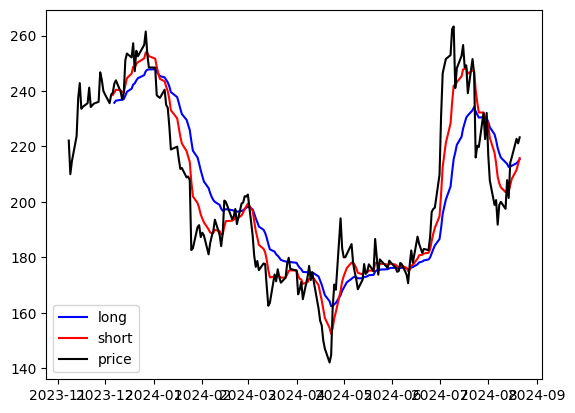

In [96]:
# Médias longa e curta
long_average = moving_average(tsla_data["Adj Close"], tsla_data["Date"], 21)
short_average = moving_average(tsla_data["Adj Close"], tsla_data["Date"], 8)

# Plotando as médias com o preço
plt.plot(long_average[round(19*long_average.size/20):], color = "blue", label = "long")
plt.plot(short_average[round(19*short_average.size/20):], color = "red", label = "short")
plt.plot(pd.Series(tsla_data["Adj Close"][round(19*long_average.size/20):].values, tsla_data["Date"][round(19*long_average.size/20):]), color = "black", label = "price")
plt.legend()